In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from typing import Any
from funcoes import aplicar_imputacao_treino,pipeline_modelagem,plot_comparacao_roc \
                    ,plot_comparacao_prc,aplicar_imputacao_teste,escolher_estrategia_imputacao \
                    ,plot_comparacao_ks,plot_comparacao_decil,gerar_tabela_avaliacao,plotar_ks_safra,calcular_ks_por_safra


In [4]:
#Lendo a base de treino
train_selecionada = pd.read_csv("train.csv")

In [5]:
#lendo a base de teste oos
test_oos = pd.read_csv("test_oos.csv")
test_oos = test_oos[train_selecionada.columns]

In [6]:
#verificando o schema
train_selecionada.shape,test_oos.shape

((6568, 81), (1643, 81))

In [7]:
# Por padrão o Pycaret não permite a imputação dinâmica de missings, então vamos tratar os missings com nossa função e depois aplicar no teste OOS do pycaret
# Assim o setup não vai precisar tratar os missings, pois o dataset não terá missings para tratar
# Vamos salvar esse pipeline e utilizar no código de escoragem

In [8]:
regra_imputacao = escolher_estrategia_imputacao(train_selecionada)
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)
test_oos = aplicar_imputacao_teste(test_oos,regra_imputacao, dict_mediana, dict_media)

In [9]:
train_selecionada.shape, test_oos.shape

((6568, 81), (1643, 81))

In [10]:
train_selecionada, test_oos, tuned_lightgbm, tuned_lr,train_lightgbm_escorado, \
test_lightgbm_escorado,train_regressao_escorado, test_regressao_escorado = pipeline_modelagem(train_selecionada, test_oos, id_col='id', safra_col='safra', target_col='y')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7904,0.7976,0.4561,0.6971,0.5508,0.4219,0.4384,0.3320
lr,Logistic Regression,0.7817,0.7890,0.4061,0.6932,0.5110,0.3830,0.4061,0.1540


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7871,0.7836,0.4392,0.6915,0.5372,0.4077,0.4254
1,0.7966,0.7935,0.4459,0.7253,0.5523,0.4302,0.4515
2,0.7928,0.8095,0.5034,0.6818,0.5792,0.4458,0.4548
3,0.7985,0.8244,0.5034,0.7009,0.5859,0.4575,0.4684
4,0.7695,0.7548,0.4324,0.6337,0.5141,0.3700,0.3816
5,0.7848,0.7901,0.4122,0.7011,0.5191,0.3923,0.4153
6,0.7924,0.7969,0.4527,0.7053,0.5514,0.4246,0.4423
7,0.8038,0.8204,0.4662,0.7419,0.5726,0.4538,0.4744
8,0.7905,0.7994,0.4459,0.7021,0.5455,0.4180,0.4362


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7852,0.7879,0.3716,0.7333,0.4933,0.3750,0.4099
1,0.7966,0.8285,0.3986,0.7662,0.5244,0.4110,0.4465
2,0.8023,0.8049,0.4698,0.7368,0.5738,0.4531,0.4726
3,0.8061,0.8281,0.4362,0.7831,0.5603,0.4486,0.4802
4,0.7829,0.7783,0.3514,0.7429,0.4771,0.3615,0.4018
5,0.7810,0.7892,0.3108,0.7797,0.4444,0.3381,0.3936
6,0.7790,0.8089,0.3716,0.7051,0.4867,0.3627,0.3929
7,0.7886,0.8158,0.3581,0.7681,0.4885,0.3767,0.4204
8,0.7886,0.7921,0.3986,0.7284,0.5153,0.3945,0.4239


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7624,0.7586,0.3649,0.6353,0.4635,0.3249,0.3455
1,0.7928,0.8278,0.4392,0.7143,0.5439,0.4196,0.4403
2,0.7795,0.7851,0.4631,0.6571,0.5433,0.4036,0.4144
3,0.8118,0.8215,0.4832,0.7660,0.5926,0.4782,0.4997
4,0.7810,0.7583,0.3986,0.6941,0.5064,0.3786,0.4027
5,0.7695,0.7904,0.3716,0.6627,0.4762,0.3431,0.3667
6,0.7886,0.7891,0.4054,0.7229,0.5195,0.3974,0.4247
7,0.7810,0.7935,0.3514,0.7324,0.4749,0.3574,0.3960
8,0.7829,0.7980,0.4257,0.6848,0.5250,0.3940,0.4127


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7757,0.7635,0.3716,0.6875,0.4825,0.3551,0.3825
1,0.7928,0.8292,0.4122,0.7349,0.5281,0.4085,0.4366
2,0.7776,0.7869,0.4094,0.6778,0.5105,0.3777,0.3978
3,0.8004,0.8224,0.4295,0.7619,0.5494,0.4337,0.4631
4,0.7810,0.7652,0.3581,0.7260,0.4796,0.3605,0.3967
5,0.7810,0.7899,0.3378,0.7463,0.4651,0.3511,0.3947
6,0.7771,0.7936,0.3446,0.7183,0.4658,0.3463,0.3836
7,0.7790,0.7950,0.3311,0.7424,0.4579,0.3438,0.3881
8,0.7771,0.7952,0.3919,0.6824,0.4979,0.3678,0.3912


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.7899,0.8035,0.3845,0.7490,0.5066,0.3907,0.4264,0.0500
1,Logistic Regression,0.7821,0.7909,0.3744,0.7194,0.4914,0.3701,0.4025,0.0090



🏆 **Modelo Vencedor:** LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.05, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=10, objective=None,
               random_state=42, reg_alpha=1, reg_lambda=0.5, subsample=0.6,
               subsample_for_bin=200000, subsample_freq=0)
✅ Regressão Logística escolhida com AUC: 0.7909


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8005,0.8399,0.4031,0.7855,0.5328,0.4222,0.4602


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7839,0.7876,0.3693,0.7308,0.4907,0.3718,0.4067


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7833,0.8037,0.3772,0.7221,0.4956,0.3745,0.4065


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7748,0.7797,0.3564,0.6962,0.4714,0.3468,0.3782


base escorada pycaret
        id   safra  VAR_1  VAR_2  VAR_3  VAR_4      VAR_5   VAR_6       VAR_7  \
0      601  201409   16.0    0.0    0.0    0.0  69.370003   189.0   36.000000   
1     4320  201409   82.0    0.0    1.0    1.0  83.559998   339.0   84.160004   
2     8725  201406  112.0    1.0    1.0    1.0  69.370003   175.0   25.170000   
3     8977  201402    0.0    0.0    0.0    0.0  67.660004  3069.0   53.980000   
4     3547  201402   20.0    0.0    0.0    0.0  40.110001   438.0  127.760002   
...    ...     ...    ...    ...    ...    ...        ...     ...         ...   
6563  3540  201405   46.0    0.0    0.0    1.0  60.950001  1309.0   19.990000   
6564  2939  201409   21.0    0.0    0.0    0.0  69.370003    77.0   53.980000   
6565  3729  201405   26.0    0.0    0.0    0.0  57.720001   772.0   50.570000   
6566  4807  201402   29.0    0.0    0.0    0.0  69.370003   281.0   53.980000   
6567  9921  201405    0.0    0.0    0.0    0.0  69.370003  3318.0   53.980000   

     

In [11]:
#Ler a base OOT
test_oot = pd.read_csv('teste_oot.csv')
test_oot = test_oot[train_selecionada.columns]

In [12]:
test_oot.shape

(2527, 81)

In [13]:
#### Escoragem dos Modelos no dataset de OOT ####
#Primeiro vamos aplicar a regra de imputação de missings
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)
test_oot = aplicar_imputacao_teste(test_oot,regra_imputacao, dict_mediana, dict_media)


In [14]:
#Agora basta escorar a base oot nos dois modelos

# 🔹 ESCORAGEM DOS MODELOS

# Aplicando LightGBM no conjunto de treino e teste
test_oot_lightgbm = predict_model(tuned_lightgbm, data=test_oot, probability_threshold=0.5, raw_score=True)
test_oot_lightgbm = test_oot_lightgbm[['id','safra','y','prediction_score_0','prediction_score_1']].rename(columns={'prediction_score_0':'score_0','prediction_score_1':'score_1'})


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6929,0.7277,0.0665,0.7500,0.1222,0.0737,0.1572


In [15]:
test_oot_regressao = predict_model(tuned_lr, data=test_oot, probability_threshold=0.5, raw_score=True)
test_oot_regressao = test_oot_regressao[['id','safra','y','prediction_score_0','prediction_score_1']].rename(columns={'prediction_score_0':'score_0','prediction_score_1':'score_1'})

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6969,0.7250,0.1108,0.6716,0.1903,0.1092,0.1775


In [16]:
train_lightgbm_escorado.head()

,id,safra,y,score_1,score_0
0,601,201409,1,0.3137,0.6863
1,4320,201409,1,0.6331,0.3669
2,8725,201406,1,0.7942,0.2058
3,8977,201402,0,0.0896,0.9104
4,3547,201402,0,0.1558,0.8442


In [17]:
test_oot_regressao.head()

,id,safra,y,score_0,score_1
0,4,201412,0,0.8623,0.1377
1,13,201411,1,0.7514,0.2486
2,15,201412,0,0.7155,0.2845
3,17,201412,0,0.4519,0.5481
4,20,201411,0,0.8400,0.1600


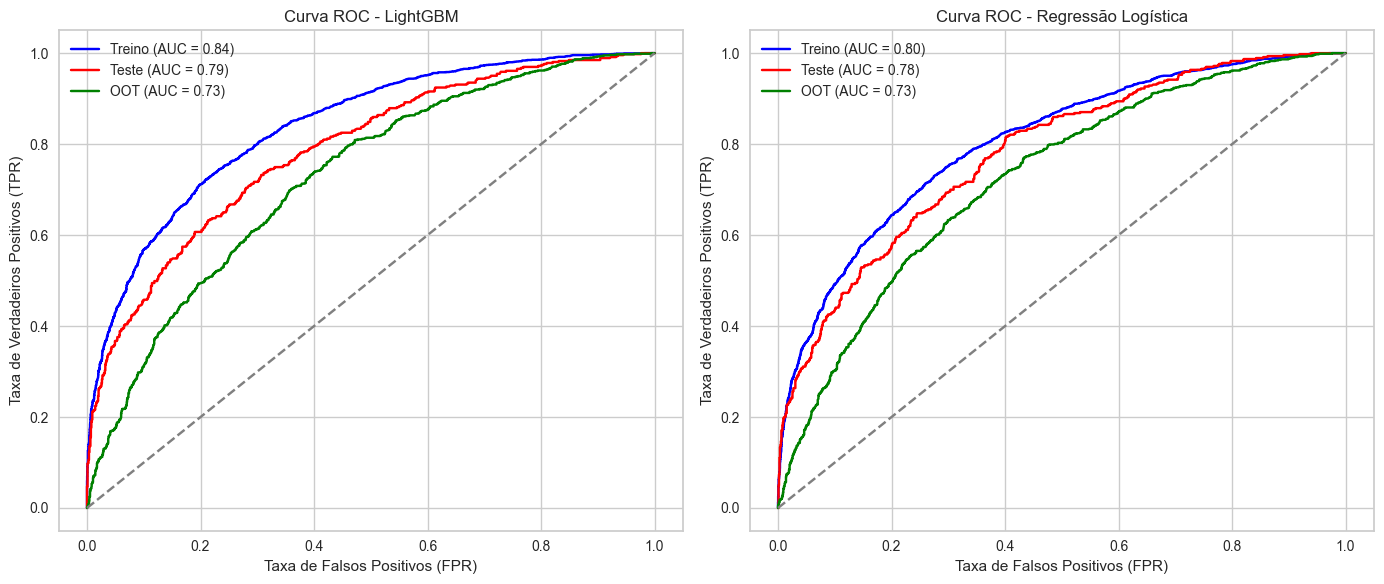

In [18]:
plot_comparacao_roc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

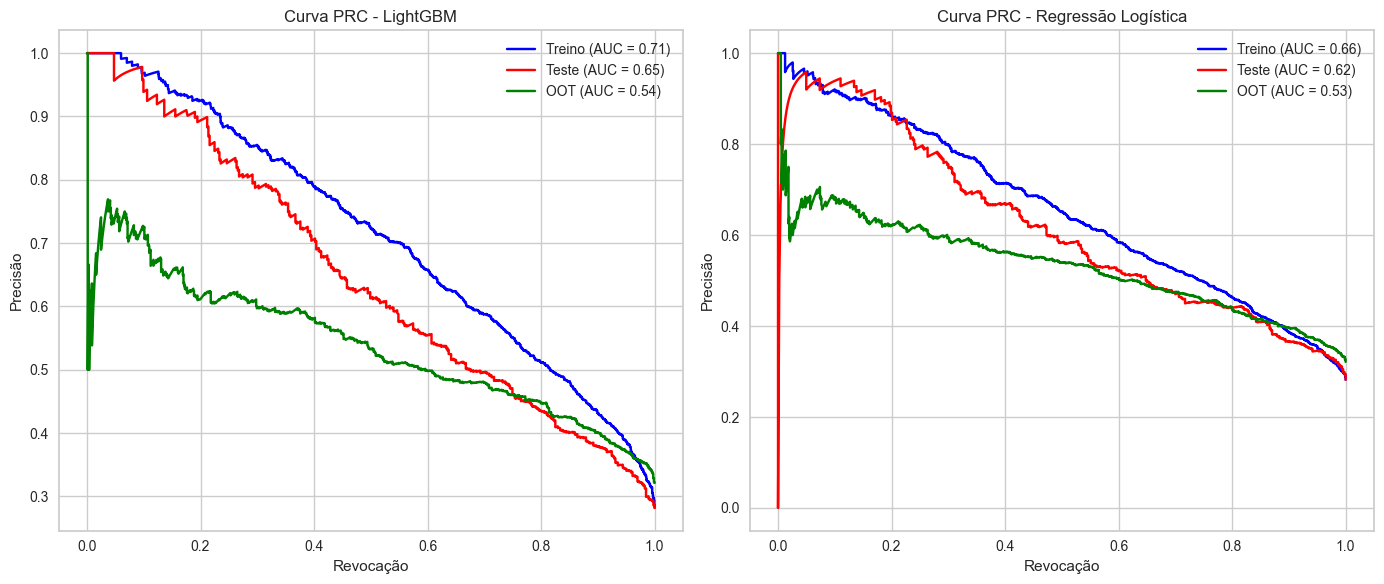

In [19]:
plot_comparacao_prc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

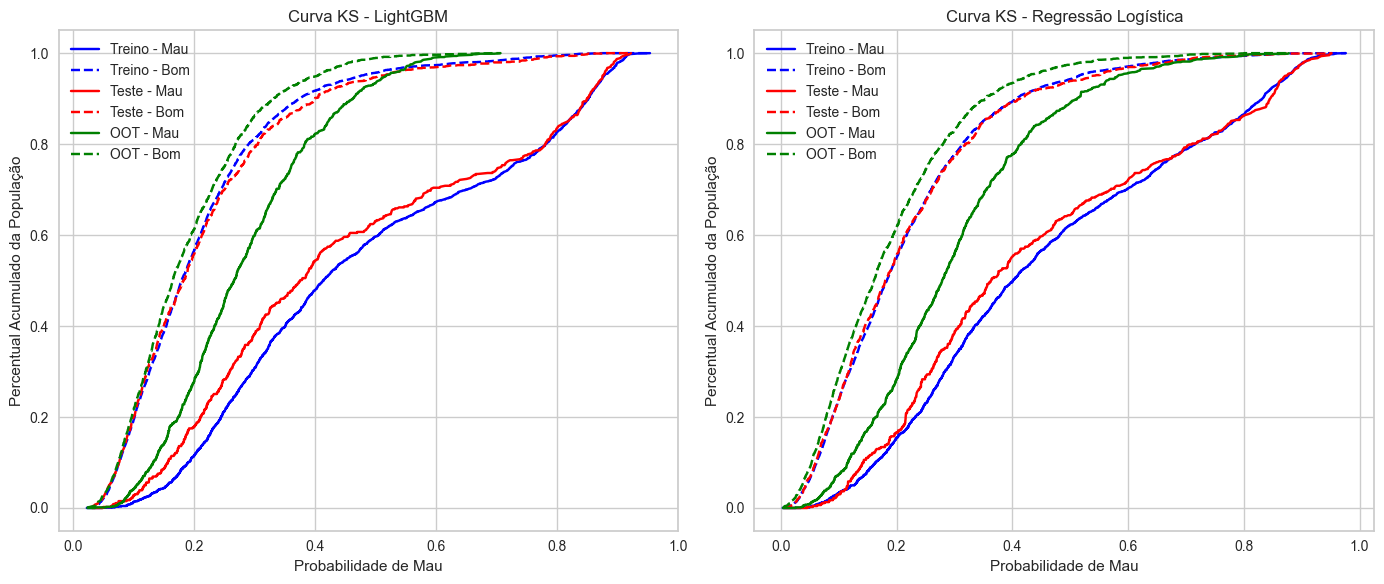

In [20]:
plot_comparacao_ks(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

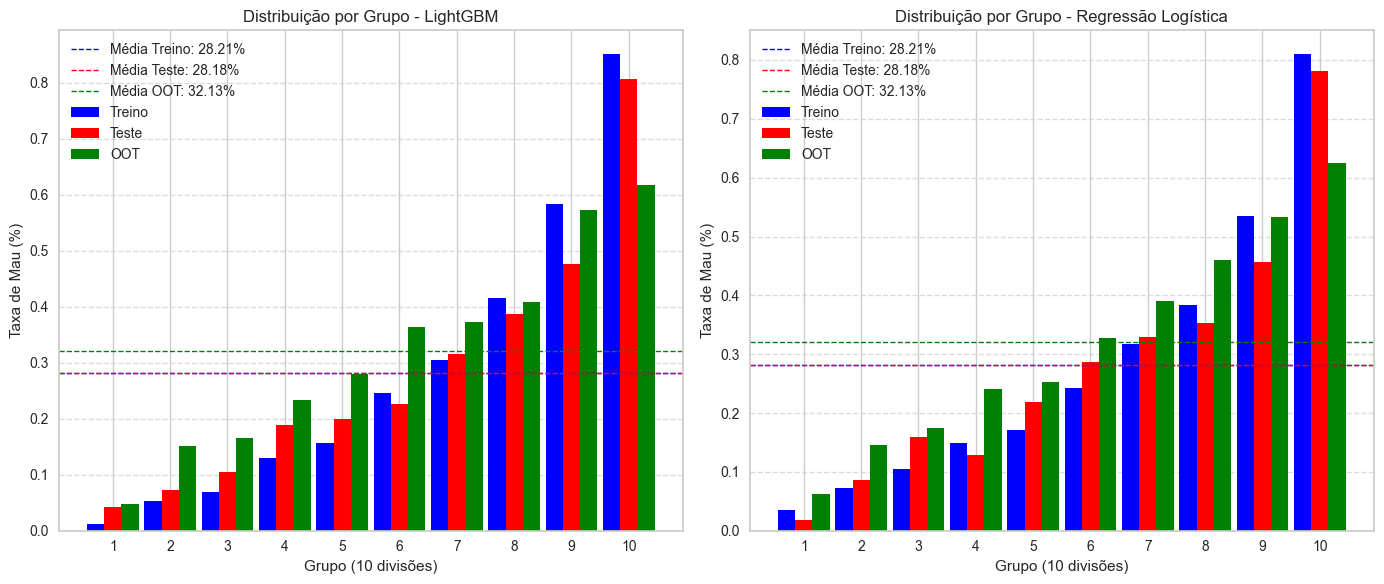

In [21]:
plot_comparacao_decil(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao,
    num_divisoes= 10)

In [22]:
tabela = gerar_tabela_avaliacao(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao,
    num_divisoes= 10)

In [23]:
tabela['nome_dataframe'].unique().tolist()

['Train LightGBM',
 'Test LightGBM',
 'Train Regressão',
 'Test Regressão',
 'OOT LightGBM',
 'OOT Regressão']

In [24]:
tabela[tabela['nome_dataframe']=="OOT LightGBM"].head(10)

,nome_dataframe,quantil,score_0 min,score_0 max,total_casos,total_mau,total_bom,maus_acumulados,% maus acumulados,KS
40,OOT LightGBM,1,0.9164,0.9759,256,12,244,12,1.477833,12.749573
41,OOT LightGBM,2,0.8872,0.9158,250,38,212,50,6.157635,20.431286
42,OOT LightGBM,3,0.8612,0.8871,253,42,211,92,11.330049,27.562079
43,OOT LightGBM,4,0.8345,0.8611,252,59,193,151,18.596059,31.549713
44,OOT LightGBM,5,0.8021,0.8344,253,71,182,222,27.339901,33.418116
45,OOT LightGBM,6,0.7702,0.8015,253,92,161,314,38.669951,31.475822
46,OOT LightGBM,7,0.7329,0.7701,252,94,158,408,50.246305,29.112295
47,OOT LightGBM,8,0.6866,0.7328,252,103,149,511,62.931034,25.115613
48,OOT LightGBM,9,0.6135,0.6862,253,145,108,656,80.788177,13.555846
49,OOT LightGBM,10,0.2935,0.6133,253,156,97,812,100.000000,0.000000


In [25]:
#ks por safra publico completo lightgbm
tabela_ks = calcular_ks_por_safra(pd.concat([train_lightgbm_escorado,test_lightgbm_escorado,test_oot_lightgbm]))

In [26]:
tabela_ks

,safra,contagem_de_linhas,ks_max,ponto_ks
0,201401,854,54.417321,0.3509
1,201402,898,53.793756,0.2956
2,201403,873,56.493768,0.2914
3,201404,955,51.001640,0.2643
4,201405,972,48.412542,0.2641
5,201406,902,53.222132,0.2746
6,201407,968,49.660428,0.2914
7,201408,912,44.242730,0.2298
8,201409,877,49.772111,0.2240
9,201410,933,36.151661,0.1797


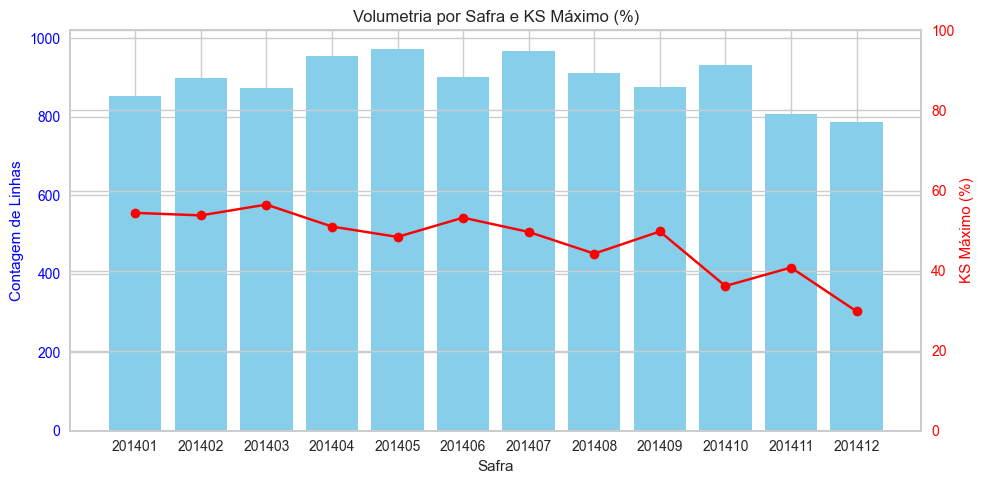

In [27]:
plotar_ks_safra(tabela_ks)